<a href="https://colab.research.google.com/github/lucasjirwin/CNN-Classifier-for-MNIST-data-set/blob/main/CNN_Classifier_for_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparing the performance of a CNN and a Feed-Forward Neural Network on the MNIST data set**

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=a94e2338d83430ef6ad589fa07c1b1cc414a4a61e35fe628bc8b882eb4577a54
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


In [ ]:
%matplotlib inline
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import random
from torchviz import make_dot

# Setting the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 10
num_classes = 10  # there are 10 digits: 0 to 9
batch_size = 256

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# checking device
print(str(device))
assert('cuda' in str(device)) 

cuda:0


In [ ]:
from torch.utils.data import DataLoader

# transforms to convert the data to PyTorch tensors and normalize
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Fetch the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=trans)

# Load the data into DataLoader objects
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,num_workers=0)

# Checking data was loaded correctly
assert(len(train_loader)*batch_size >= 60000)
assert(len(test_loader)*batch_size >=10000)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Trainer class to train the FFNN and CNN
class Trainer():
  # Initalize Trainer
    def __init__(self,net=None,optimizer=None,loss_f=None, train_loader=None):
        self.net = net
        self.optimizer = optimizer
        self.loss_f = loss_f
        self.train_loader = train_loader
    # Function to train network 
    def train(self,epochs):
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            steps= 0
            for images in self.train_loader:
              
                X = images[0].to(device) # shape = 256,1,28,28 (batch_size, channels, height, width)
                y = images[1].to(device) # shape = 256 (class labels for the batch)
                
                # Zero the optimizer for this batch
                self.optimizer.zero_grad() 
                out = self.net(X) # make predictions
                loss = self.loss_f(out, y) # Compute loss
                loss.backward() # Backpropagation to compute gradients
                self.optimizer.step() # Update parameters 

                epoch_loss += loss.item()
                steps += 1
            # average loss of epoch
            losses.append(epoch_loss / steps)
            print("epoch [%d]: loss %.3f" % (epoch+1, losses[-1]))
        return losses

# **Feed-Forward Neural Network (FFNN)**

In [ ]:
# Feed-Forward Neural Network Class
class FFNN(nn.Module):
  # Initliaze the Network
  def __init__(self):
    super(FFNN,self).__init__()
    self.input_size = 28*28
    self.fc1 = nn.Linear(self.input_size, 2000) # input -> hidden layer 1
    self.fc2 = nn.Linear(2000, 1500) # hidden layer 1 -> hidden layer 2
    self.fc3 = nn.Linear(1500, 500) # hidden layer 2 -> hidden layer 3
    self.fc4 = nn.Linear(500, 10) # hidden layer 3 -> output
  # Make predictions
  def forward(self,x):
    x = x.view(-1, self.input_size) # Flattens to 1D
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x 


## Train Feed-Forward Network

In [ ]:
net = FFNN()
a = net.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = optim.SGD(params = net.parameters(), lr = 0.01, momentum = 0.9)

trainer = Trainer(net = net, optimizer = optimizer, loss_f = loss_f, train_loader = train_loader) 
losses = trainer.train(epochs =num_epochs)

epoch [1]: loss 0.653
epoch [2]: loss 0.193
epoch [3]: loss 0.131
epoch [4]: loss 0.096
epoch [5]: loss 0.072
epoch [6]: loss 0.055
epoch [7]: loss 0.043
epoch [8]: loss 0.034
epoch [9]: loss 0.025
epoch [10]: loss 0.020


## Visaulize Loss per epoch 

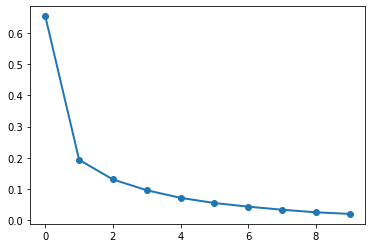

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses, linewidth=2, linestyle='-', marker='o')

## Evaluate performance on Test set

In [ ]:
err = 0
tot = 0
net.eval()
with torch.no_grad():
    for images in test_loader:
        # Get batches of data
        X = images[0].to(device) 
        y = images[1].to(device) 

        # Network Predictions
        out = net(X)
        
        # let the maximum index be our predicted class
        _, yh = torch.max(out, 1) 

        # tot will 10,000 at the end, total number of test data
        tot += y.size(0)

        # number of indices for which yh and y are not equal
        err += (yh != y).sum().item() #ACT18

print('Accuracy of FC prediction on test digits: %5.2f%%' % (100-100 * err / tot))

Accuracy of FC prediction on test digits: 98.10%


# **Convolutional Neural Network (CNN)**

In [ ]:
# Convolutional Neural Network Class
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1,32,kernel_size=5, stride =1,padding=2)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
    self.conv2 = nn.Conv2d(32,64,kernel_size=5,stride=1,padding=2) 
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 

    self.size_linear = 7*7*64 
    self.fc1 = nn.Linear(self.size_linear, 512)
    self.fc2 = nn.Linear(512, 10) 
  # Make predictions  
  def forward(self, x):
      x = self.pool1(F.relu(self.conv1(x))) 
      x = self.pool2(F.relu(self.conv2(x)))
      x = x.view(-1, self.size_linear)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x 

## Train CNN

In [ ]:
net = CNN()
a = net.to(device)
optimizer = optim.SGD(params = net.parameters(), lr = 0.01, momentum = 0.9)
loss_f = nn.CrossEntropyLoss()

trainer = Trainer(net = net, optimizer = optimizer, loss_f = loss_f, train_loader = train_loader)

losses = trainer.train(epochs = num_epochs)

epoch [1]: loss 0.363
epoch [2]: loss 0.076
epoch [3]: loss 0.053
epoch [4]: loss 0.040
epoch [5]: loss 0.033
epoch [6]: loss 0.028
epoch [7]: loss 0.024
epoch [8]: loss 0.020
epoch [9]: loss 0.018
epoch [10]: loss 0.014


## Visualize Loss per Epoch

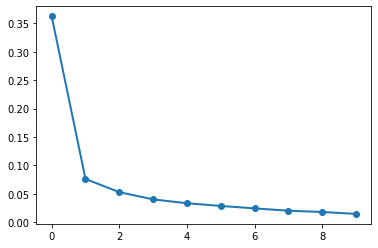

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses, linewidth=2, linestyle='-', marker='o')

## Evaluate performance on Test set

In [ ]:
err = 0
tot = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
      
        X = data[0].to(device) 
        y = data[1].to(device) 

        # network predictions
        output = net(X)
        
        # let the maximum index be our predicted class
        _, yh = torch.max(output, 1) 

        # tot will 10,000 at the end, total number of test data
        tot += y.size(0)

        # number of indices for which yh and y are not equal
        err += (yh != y).sum().item() 
print('Accuracy of prediction on test digits: %5.2f%%' % (100-100 * err / tot))

# Checking correctness
assert((100-100 * err / tot)>=98)
assert(tot==10*1000)

Accuracy of prediction on test digits: 99.08%
